# Notebooks for NCDE raining

This is a interactive notebook supplementary to the study "Neural controlled differential equation and its application in pharmacokinetics and pharmacodynamics" (Wu et al. 2025, *CPT: Pharmacomet. Syst. Pharmacol.*). The notebook would be helpful for the replication of the results of neural controlled differential equation (NCDE) model investigated in the study, and it can also be regarded as a user guide of NCDE modeling for PK and PD scenarios.

The import section, training section and model declaration are modified from the NCDE example provided on Diffrax documentation (https://docs.kidger.site/diffrax/examples/neural_cde/). However, intensive modifications were added by the authors for the purpose of the study, such as data simulations, changes of the model structure, L1 regularizations, derivative obtaining and abundant comments.

Note that the grammar under **JAX** framework is different from Tensorflow and PyTorch. Some basic differences that frequently occur in this notebook include:

 - Vectorization using `jax.vmap`. Generally speaking, this is one way to avoid using loops and speed up the computation.

 - Management of pseudo number using `jax.random.PRNGKey` and `jax.random.split`. Keys are imperative for model initialization and random number generation, which is also helpful for replication. However, to replicate all the simulated data in the study, except setting seed to be `2024`, the version of `jax` and `jaxlib` should be `0.4.38`.

 - Changing array content via `a = a.at[index].set(value)`, instead of `a[index]=value`.

This notebook can be run on Google Colab directly.




---


Copyright 2025 Zhisong Wu et al.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


---



In [ ]:
# to replicate the simulated data:
# !pip install jaxlib==0.4.38
# !pip install jax==0.4.38
pip install diffrax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalle

In [ ]:
# Import all relevant libraries
# Note that Numpy might be upgraded to 2.0 or higher, which is likely to lead to error
# When this happened, reinstall Numpy with lower version is a possible solution
import math
import time

import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp

import diffrax
import equinox as eqx
import optax

import matplotlib
import matplotlib.pyplot as plt

The dimensionality of follwing cells is worth noticing:

Initial: $\mathbb{R}^{data}\rightarrow \mathbb{R}^{hidden}$, as $\mathbf{z}(0) = h_{ini}(\mathbf{x})$

Func: $\mathbb{R}^{hidden}\rightarrow \mathbb{R}^{hidden\times data}$, as the result of matrix multiplication $g(\mathbf{z})\cdot d\mathbf{x} $ has the dimension of $d\mathbf{z}$

Linear: $\mathbb{R}^{hidden}\rightarrow \mathbb{R}^{target}$, as $\mathbf{y}(t) = h_{linear}(\mathbf{z})$

In [ ]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    data_size: int
    hidden_size: int

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.data_size = data_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y).reshape(self.hidden_size, self.data_size)

In [ ]:
class NeuralCDE(eqx.Module):
    initial: eqx.nn.MLP
    func: Func
    linear: eqx.nn.Linear

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3)
        self.initial = eqx.nn.MLP(data_size, hidden_size, ..., 0, key=ikey)
        # MLP with 0 hidden layers: equivalent of a linear layer
        # we have tried initial MLP with different numbers of the units in the hidden layers
        # but it turns out that a linear layer worked better
        self.func = Func(data_size, hidden_size, width_size, depth, key=fkey)
        self.linear = eqx.nn.Linear(hidden_size, 1, key=lkey)

    def __call__(self, ts, coeffs, evolving_out=True):
        control = diffrax.CubicInterpolation(ts, coeffs)
        # for discrete control term, interpolation could produce continous paths
        # which is necessary for NCDE training

        #term = diffrax.ControlTerm(self.func, control).to_ode()
        # although original implementation of NCDE by Kidger utilize a 'to_ode' command,
        # NCDE is not always convertable to NODE, therefore 'to_ode()' is not always a reasonable choice

        term = diffrax.ControlTerm(self.func, control)
        solver = diffrax.Heun()

        # following solvers might run slower, but it is helpful to compare their performaces
        #solver = diffrax.ImplicitEuler()
        #solver = diffrax.Kvaerno3()
        #solver = diffrax.Dopri8()
        #solver = diffrax.Kvaerno5()

        dt0 = None
        y0 = self.initial(control.evaluate(ts[0]))

        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller = diffrax.PIDController(rtol=1e-3, atol=1e-4),
            saveat = saveat,
            #max_steps = 2*8192
            # sometimes, a Run Time Error will occur, indicating that the 'step reaching maximum'
            # in this case, we might increase the max_steps
            # however, using a solver with lower order might be a more sustainable choice
        )
        # solution shape: (time_steps, hidden_dim)

        if evolving_out:
            prediction = jax.vmap(lambda y: jnn.relu(self.linear(y)))(solution.ys)
            # relu function is just to eliminate negative value
            # but in fact, not using relu function might be a more suitable choice,
            # since the data of PK and PD scenarios studied in this work are all positive
        else:
            (prediction,) = jnn.relu(self.linear(solution.ys[-1]))

        return prediction


### Simulation of datasets

The code below might seem bizzare, for the rules under JAX environment is not similar to the coding method that most developers are accustomed to. For example, we should use ```
a.at[index].set(value)```to change the value in the array.

The simulation codes for other PK and PD settings are at the appendix.

In [ ]:
period = 12
dose = 1
period_stop = 5

def phase(t): # that is, time since last dose
    pre_period = int(jnp.floor(t/period))
    if pre_period >= period_stop:
        return t - period_stop * period
    return t - pre_period * period

def func_1(t):
    kel = 0.06
    kin = 0.6
    pre_period = int(jnp.floor(t/period))
    R = 0
    R_2 = 0
    for i in range(0, pre_period + 1):
        if i >= period_stop:
            break
        R = R + dose * jnp.exp(- i * kel * period)
        R_2 = R_2 + dose * jnp.exp(- i * kin * period)
    return R * jnp.exp(- kel * phase(t)) - R_2 * jnp.exp(- kin * phase(t))


def func_2(t):
    kel = 0.06
    kin = 0.6
    pre_period = int(jnp.floor(t/period))
    R = 0
    R_2 = 0
    for i in range(0, pre_period + 1):
        if i >= period_stop:
            break
        R = R + dose * jnp.exp(- i * kel * period)
        R_2 = R_2 + dose * jnp.exp(- i * kin * period)
    return R * 5 * jnp.exp(- kel * phase(t)) - R_2 * 5 * jnp.exp(- kin * phase(t))


def get_data_pk(dataset_size, add_noise, *, key):

    time_sample_key, noise_key = jr.split(key, 2)
    time_points = 19 # 20-1
    # we want to randomly generate the rest 19 time points first,
    # and then append the first time point (t=0) at the beginning
    time_sample_ = jr.uniform(time_sample_key, (dataset_size, time_points), minval = 0.01, maxval = 108)
    time_sample_ = jnp.sort(time_sample_, axis = -1)
    zeros_initial = jnp.zeros((dataset_size, 1))
    time_sample = jnp.concat((zeros_initial, time_sample_), axis = -1)

    # the datasets is split into two doses
    time_points = 20
    ys1 = jnp.zeros(shape = (dataset_size//2, time_points))
    ys2 = jnp.zeros(shape = (dataset_size - dataset_size//2, time_points))

    phase_label_1 = jnp.zeros(shape = ys1.shape)
    phase_label_2 = jnp.zeros(shape = ys2.shape)

    for i in range(dataset_size//2):
        for j in range(time_points):
            ys1 = ys1.at[i,j].set(func_1(time_sample[i,j]))
            phase_label_1 = phase_label_1.at[i,j].set(phase(time_sample[i,j]))

    for i in range(dataset_size - dataset_size//2):
        for j in range(time_points):
            i_ = dataset_size//2 + i
            ys2 = ys2.at[i,j].set(func_2(time_sample[i_,j]))
            phase_label_2 = phase_label_2.at[i,j].set(phase(time_sample[i_,j]))

    dose_label = jnp.zeros(shape = time_sample.shape)
    dose_label = dose_label.at[:dataset_size//2,:].set(1.0)
    dose_label = dose_label.at[dataset_size//2:,:].set(5.0)

    phase_label = jnp.concatenate((phase_label_1, phase_label_2), axis = 0)

    features = jnp.stack((time_sample, phase_label, dose_label), axis = -1)

    coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(time_sample, features)
    # to calculate the interpolation term used for NCDE prediction
    # (see the line: control = diffrax.CubicInterpolation(ts, coeffs))
    # we have to calculate a set of coefficient first.
    # and since a CubicInterpolation is used,
    # coefficients with 4 dimension was calculated
    # because in 'y = ax^3 + bx^2 + cx + d', there are 4 coefficients in total

    data_size = features.shape[-1]

    if add_noise:
        ys1 = ys1 + jr.normal(noise_key, ys1.shape) * 0.05 # a smaller noise for low dose dataset
        (noise_key, ) = jr.split(noise_key, 1)
        ys2 = ys2 + jr.normal(noise_key, ys2.shape) * 0.1 # a larger noise for low dose dataset


    ys = jnp.concatenate((ys1, ys2), axis = 0)
    ys = jnp.clip(ys, min = 0) # in case that negative values occur

    return time_sample, coeffs, features, ys, data_size

In [ ]:
# the dataloader section is from Kidger
# except the fuction of loading all data (batch_size = data_size) is added
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        if batch_size == dataset_size:
            batch_perm = perm[:]
            #print(batch_perm)
            yield tuple(array[batch_perm] for array in arrays)

        while end < dataset_size:
            batch_perm = perm[start:end]
            #print(batch_perm)
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

In [ ]:
seed = 2024
dataset_size = 44
add_noise = True
key = jr.PRNGKey(seed)
train_data_key, test_data_key, model_key, loader_key = jr.split(key, 4)

# note that a seed for Pseudo-Random-Number-Genearion (PRNGKey) is imperative under JAX environment
# 'split' command can split the seed into any numer, which is used to preserve the randomness from the original key

ts, coeffs, features, ys, data_size = get_data_pk(
    dataset_size, add_noise, key=train_data_key
)

print(ts.shape)
print(features.shape)
print(ys.shape)

test_size = 4
ts_test, coeffs_test, _, ys_test, __ = get_data_pk(test_size, add_noise = True, key=test_data_key)

(44, 20)
(44, 20, 3)
(44, 20)


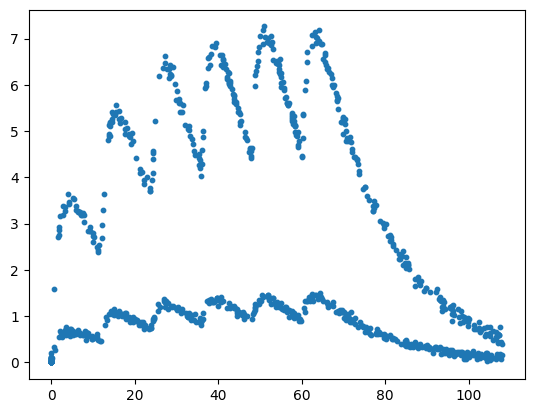

In [ ]:
plt.scatter(ts, ys, s = 10) # it is helpful to check the simulation results

### Model Training

In [ ]:
hidden_size = 6
# hidden_size = 8 # for extravascular administration PK with nonlinear elimination
width_size = 128
depth = 1

model = NeuralCDE(data_size, hidden_size, width_size, depth, key=model_key)

In [ ]:
# the training loop is modified from Kidger et al.
# WMSE version
"""
@eqx.filter_jit
def loss(model, ti, label_i, coeff_i, l1):
    pred = jax.vmap(model)(ti, coeff_i)[:,:,0]
    wmse = jnp.mean(jnp.power((pred-label_i), 2)/(label_i + 1e-3))

    l1_reg = 0
    l1_lambda = l1
    for i in model.initial.layers + model.func.mlp.layers + (model.linear,):
        l1_reg += jnp.sum(jnp.abs(i.weight)) + jnp.sum(jnp.abs(i.bias))
    l1_reg = l1_reg * l1_lambda

    l1_loss = l1_reg + wmse

    return l1_loss, wmse
"""

# MSE version
@eqx.filter_jit
def loss(model, ti, label_i, coeff_i, l1):
    pred = jax.vmap(model)(ti, coeff_i)[:,:,0]
    mse = jnp.mean(jnp.power((pred-label_i), 2))

    l1_reg = 0
    l1_lambda = l1
    for i in model.initial.layers + model.func.mlp.layers + (model.linear,):
        l1_reg += jnp.sum(jnp.abs(i.weight)) + jnp.sum(jnp.abs(i.bias))
    l1_reg = l1_reg * l1_lambda

    l1_loss = l1_reg + mse

    return l1_loss, mse

grad_loss = eqx.filter_value_and_grad(loss, has_aux = True)

@eqx.filter_jit
def make_step(model, data_i, opt_state, l1):
    ti, feature_i, ys, *coeff_i = data_i
    (loss_l1, mse), grads = grad_loss(model, ti, ys, coeff_i, l1)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss_l1, mse, model, opt_state

In [ ]:
lr = 1e-3

optim = optax.adamax(lr)
# You might want to test the performance of the following optimizer
# but we recommend using AdaMax optimizer for NCDE training
#optim = optax.adam(lr)
#optim = optax.nadam(lr)
#optim = optax.adagrad(lr)
#optim = optax.yogi(lr)
#optim = optax.rmsprop(lr)
#optim = optax.amsgrad(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

loss_train_note = []
mse_train_note = []
loss_test_note = []
mse_test_note = []
func_note = []

**Potential RTEs**: In the following training procedures, we use ```try:...except:...``` to skip **potential Run Time Errors (RTEs)**. This is because inappropriate optimizers or high-order numerical solvers will lead to a RTE that halts the training process. But sometimes, this problem only happens for specific batch of data. Therefore, if we ignore the RTE and let NCDE train on next batch, the model will generally be converged.

But for the AdaMax + Heun + L1 regularization combination provided in this study, RTE generally will **NOT** happen. If a RTE (or tons of RTEs) still occur, it is helpful to move the code outside of ```try:...except:...``` to debug efficiently.   

**Choice of L1 regularization coefficient**: It is encouraged to manually fine-tune the L1 regularization coefficient when monitoring the performance of the model. Empirically, when the model is not accurate enough, `l1` can be reduced to increase accuracy. On the contrary, when extrapolation performance is bad, `l1` should be increased. When dataset size and batch size are different, a new experiment is suggested to obatin a most suitable L1 regularization coefficient.

In [ ]:
batch_size = 8
#batch_size = 16
print_step = 100
steps = 16000 # typically 16000~22000

# l1 coefficient
l1 = 5e-3
#l1 = 1e-2
#l1 = 0


min_loss = 999999999
min_mse = 999999999

all_start_time = time.time()

for step, data_i in zip(
    range(steps), dataloader((ts, features, ys) + coeffs, batch_size, key=loader_key)
):
    start = time.time()

    try:
        loss_l1, mse, model, opt_state = make_step(model, data_i, opt_state, l1)
        # only batch gradient was used to update the model
        loss_l1_test, mse_test = loss(model, ts_test, ys_test, coeffs_test, l1)
        loss_l1_train, mse_train = loss(model, ts, ys, coeffs, l1)
    except:
        print(f'  Training RTE at step {step}')
        continue
    end = time.time()

    # some other criteria could also be used
    # such as loss_test, loss_train and mse_train
    if mse_test < min_mse and mse_test < 0.5:
        eqx.tree_serialise_leaves('model.eqx', model)
        print(f'Min Train MSE {mse_train:.8f} at step {step}')
        min_mse = mse_test

    # record the loss and the mse
    loss_train_note.append(loss_l1)
    loss_test_note.append(loss_l1_test)
    mse_train_note.append(mse)
    mse_test_note.append(mse_test)

    if step%print_step == 0:
        # record the trajectory of the update process of model parameters
        func_note.append((model.func.mlp.layers[0].weight,model.func.mlp.layers[1].weight))
        ti, feature_i, yi, *coeff_i = data_i
        try:
            pred = jax.vmap(model)(ti, coeff_i)[:,:,0]
        except:
            print(f'   Print RTE at step {step}')

        if step == steps-1:
            plt.scatter(ti, yi, color = 'blue', s = 15, label = 'Data Obs')
            plt.scatter(ti, pred, color = 'red', s = 10, label = 'NCDE Pred')
            plt.xlabel('Time/h')
            plt.ylabel('Concentration/(mg/L)')
            # plt.ylabel('Effect') # in PD settings
            plt.legend()
        print(f"Step: {step}, Train Loss: {loss_l1_train:.8f}, Test loss: {loss_l1_test:.8f}, Computation time: {(end - start):.8f}")
        print(f"Train MSE: {mse_train:.8f}, Test MSE: {mse_test:.8f}")

all_end_time = time.time()
print(f'Duration: {(all_end_time - all_start_time):.8f}')

### Analysis of Training Results

In [ ]:
# saving model
eqx.tree_serialise_leaves('model.eqx', model)
# loading the saved model
# model = eqx.tree_deserialise_leaves('model', model)

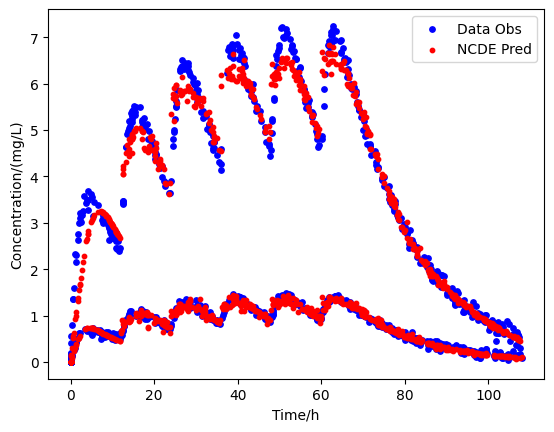

In [ ]:
# Discrete dots prediction (one-to-one)

pred = jax.vmap(model)(ts, coeffs)[:,:,0]

plt.scatter(ts, ys, color = 'blue', s = 15, label = 'Data Obs')
plt.scatter(ts, pred, color = 'red', s = 10, label = 'NCDE Pred')
plt.xlabel('Time/h')
plt.ylabel('Concentration/(mg/L)')
plt.legend()
plt.savefig('NCDE_all.png', dpi = 300, pad_inches = 0)

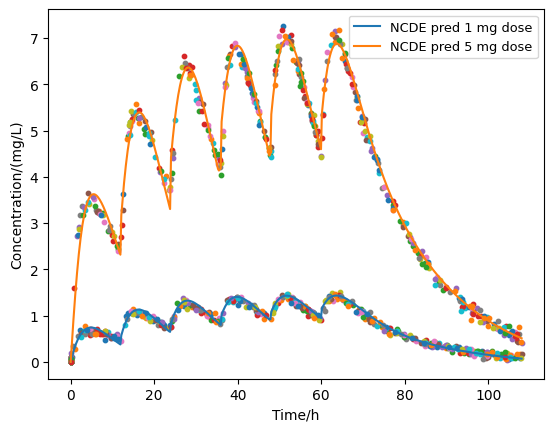

In [ ]:
# Fitting

dense_time_points = 500
t_dense = jnp.expand_dims(jnp.linspace(0.001, 108, dense_time_points), 0)
phase_dense = jnp.zeros(shape = t_dense.shape)

for i in range(dense_time_points):
    phase_dense = phase_dense.at[0,i].set(phase(t_dense[0,i]))

dose_dense_1 = jnp.ones(shape = t_dense.shape)
dose_dense_2 = jnp.ones(shape = t_dense.shape)
dose_dense_2 = dose_dense_2.at[:].set(5.0)

feature_dense_1 = jnp.stack((t_dense, phase_dense, dose_dense_1), axis = -1)
feature_dense_2 = jnp.stack((t_dense, phase_dense, dose_dense_2), axis = -1)


coeffs_1 = jax.vmap(diffrax.backward_hermite_coefficients)(t_dense, feature_dense_1)
coeffs_2 = jax.vmap(diffrax.backward_hermite_coefficients)(t_dense, feature_dense_2)

pred_dense_1 = jax.vmap(model)(t_dense, coeffs_1)[:,:,0]
pred_dense_2 = jax.vmap(model)(t_dense, coeffs_2)[:,:,0]

plt.plot(t_dense[0], pred_dense_1[0], label = 'NCDE pred 1 mg dose')
plt.plot(t_dense[0], pred_dense_2[0], label = 'NCDE pred 5 mg dose')

for i in range(dataset_size):
    plt.scatter(ts[i], ys[i], s = 10)

plt.xlabel('Time/h')
plt.ylabel('Concentration/(mg/L)')
plt.legend(prop = {'size':9.3})
plt.savefig('exp.png', dpi = 400, pad_inches = 0)

In [ ]:
# Visualization of Training Process
plt.plot(jnp.log(jnp.array(mse_train_note)), label = 'Train MSE')
plt.plot(jnp.log(jnp.array(mse_test_note)), label = 'Test MSE')
plt.plot(jnp.log(jnp.array(loss_train_note)), label = 'Train Loss (with L1 term)')
plt.plot(jnp.log(jnp.array(loss_test_note)), label = 'Test Loss (with L1 term)')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss and WMSE (log scale)')
#plt.ylabel('Loss and WMSE (log scale)')
plt.savefig('loss_all_stages.png', dpi = 400, bbox_inches = 'tight')

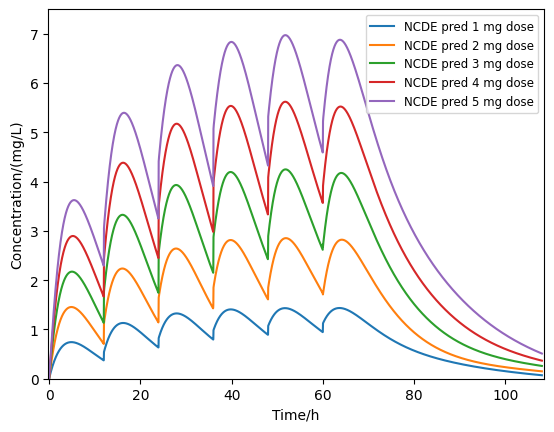

In [ ]:
# Extrapolation

dense_time_points = 5000
t_dense = jnp.expand_dims(jnp.linspace(0.001, 108, dense_time_points), 0)
phase_dense = jnp.zeros(shape = t_dense.shape)

for i in range(dense_time_points):
    phase_dense = phase_dense.at[0,i].set(phase(t_dense[0,i]))

dose_range = jnp.array([1,2,3,4,5])

for i in range(0, len(dose_range)):
    dose_dense_i = jnp.ones(shape = t_dense.shape)
    dose_dense_i = dose_dense_i.at[:].set(dose_range[i])
    feature_dense_i = jnp.stack((t_dense, phase_dense, dose_dense_i), axis = -1)
    coeffs_i = jax.vmap(diffrax.backward_hermite_coefficients)(t_dense, feature_dense_i)
    pred_dense_i = jax.vmap(model)(t_dense, coeffs_i)[:,:,0]
    plt.plot(t_dense[0], pred_dense_i[0], label = f'NCDE pred {dose_range[i]} mg dose')


plt.xlabel('Time/h')
plt.ylabel('Concentration/(mg/L)')
plt.xlim(-0.2,108.5)
#plt.ylim(0,7.3)
#plt.xlim(40,60)
plt.ylim(0,7.5)
plt.legend(prop = {'size':8.5})
#plt.legend()
plt.savefig('Extrapolation.png', dpi = 400, bbox_inches = 'tight')

In [ ]:
# showing test and mse
loss_l1_test, mse_test = loss(model, ts_test, ys_test, coeffs_test, l1)
print(f'loss_l1_test: {loss_l1_test:.8f}, test_mse: {mse_test:.8f}')
loss_l1_train, mse_train = loss(model, ts, ys, coeffs, l1)
print(f'loss_l1_train: {loss_l1_train:.8f}, mse_train: {mse_train:.8f}')

In [ ]:
# visualizing model parameters
plt.imshow(model.func.mlp.layers[1].weight, cmap = 'bwr', vmin = -0.2, vmax = 0.2)
plt.xticks([])
plt.yticks([])
#plt.colorbar(shrink = 0.2)
plt.savefig('EXP_weights.png', dpi = 400, pad_inches = 0)

In [ ]:
# saving training records
jnp.save('mse_test',jnp.array(mse_test_note))
jnp.save('mse_train',jnp.array(mse_train_note))
jnp.save('loss_train',jnp.array(loss_train_note))
jnp.save('loss_test',jnp.array(loss_test_note))

In [ ]:
# saving model training trajectory
func_0_note = []
func_1_note = []
for i in range(len(func_note)):
    func_0_note.append(func_note[i][0])
    func_1_note.append(func_note[i][1])
jnp.save('func_0_note', jnp.array(func_0_note))
jnp.save('func_1_note', jnp.array(func_1_note))

### Obtaining Derivatives

There are generally two ways to obtain a derivative, one **numerically** (not reflecting real hidden dynamics of NCDE, using `sol.derivative` function), another **accurately** (via **vector field**, using `vector_field(t, sol.evaluate(t), args)` function). See diffrax documentation  (https://docs.kidger.site/diffrax/api/solution/ and https://docs.kidger.site/diffrax/api/terms/#diffrax.ControlTerm) for more details. Here, we use the accurate approach to obtain hidden dynamics of vector field, and then calculate the derivative.

The derivatives in the minimal region at the discontinous points (or break-points) are not accurate, because the derivatives at those points are not well-defined. We have omitted the break-points correspondingly using `clip` function, which is helpful for better illustraion.

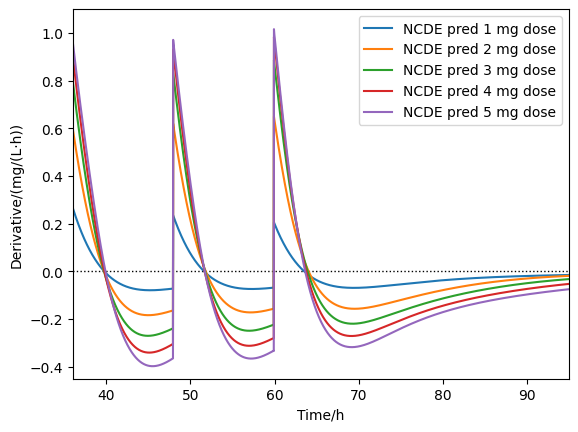

In [ ]:
def clip_dr(a, lower_bound, upper_bound):
    a: jnp.array
    a_ = a[jnp.where(a > lower_bound)]
    idx = jnp.where(a_ < upper_bound)
    a__ = a_[idx]
    return a__, idx

def get_derivative_accurate(t_, coeffs_):
    c = diffrax.CubicInterpolation(t_, coeffs_)
    # interpolation is needed to calculate dx/dt
    term = diffrax.ControlTerm(model.func, c)
    # namely g(x), the vector field controlled by control variable x
    solver = diffrax.Heun()
    # note that the solver here should be in line with the trained model
    dt0 = None
    y0 = model.initial(c.evaluate(t_[0]))
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t_[0],
        t_[-1],
        dt0,
        y0,
        stepsize_controller=diffrax.PIDController(rtol = 1e-3, atol = 1e-4),
        saveat=diffrax.SaveAt(dense=True)
    )

    # which is just g(x)(dx/dt)
    dr = jax.vmap(lambda t: term.vector_field(t, sol.evaluate(t), ...)
             @ c.derivative(t))(t_dense[0])

    # which is a much faster version of following codes:
    #dr = []
    #for i in range(t_dense.shape[-1]):
    #    dr.append(term.vector_field(t_dense[0, i], sol.evaluate(t_dense[0, i]), ...)
    #             @ c.derivative(t_dense[0, i]))
    #dr = jnp.array(dr)

    # only weight is preserved after taking derivatives
    out = model.linear.weight @ jnp.transpose(dr)
    return out

plt.plot([-10,110],[0,0], color = 'black', linestyle = ":", linewidth = 1)

for i in range(0, len(dose_range)):
    dose_dense_i = jnp.ones(shape = t_dense.shape)
    dose_dense_i = dose_dense_i.at[:].set(dose_range[i])
    feature_dense_i = jnp.stack((t_dense, phase_dense, dose_dense_i), axis = -1)
    coeffs_i = jax.vmap(diffrax.backward_hermite_coefficients)(t_dense, feature_dense_i)
    dr_i = jax.vmap(get_derivative_accurate)(t_dense, coeffs_i)[0]
    clip_dr_i, idx_i = clip_dr(dr_i, -1, 1.5)
    # the reason to clip is seen above
    # the threshold is adjusted empirically
    plt.plot(t_dense[0][idx_i[0]], clip_dr_i, label = f'NCDE pred {dose_range[i]} mg dose')

#plt.legend(prop = {'size':9})
plt.legend()
plt.xlabel('Time/h')
plt.ylabel('Derivative/(mg/(L·h))')
plt.ylim(-0.45, 1.1)
plt.xlim(36, 95)
#plt.ylim(-0.5, 1.2)
plt.savefig('Accurate_Derivative.png', dpi = 400, pad_inches = 0)

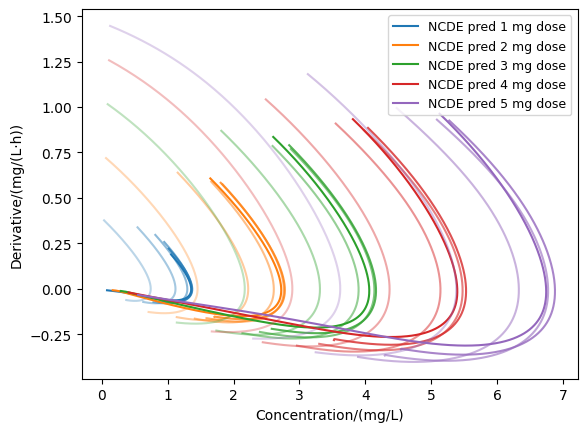

In [ ]:
import matplotlib.pyplot as plt

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
alphas = [0.3, 0.4, 0.5, 0.6, 0.8]


for i in range(0, len(dose_range)):
    dose_dense_i = jnp.ones(shape=t_dense.shape)
    dose_dense_i = dose_dense_i.at[:].set(dose_range[i])
    feature_dense_i = jnp.stack((t_dense, phase_dense, dose_dense_i), axis=-1)
    coeffs_i = jax.vmap(diffrax.backward_hermite_coefficients)(t_dense, feature_dense_i)
    dr_i = jax.vmap(get_derivative_accurate)(t_dense, coeffs_i)[0]


    pred_dense_i = jax.vmap(model)(t_dense, coeffs_i)[:,:,0]

    clip_dr_i, idx_i = clip_dr(dr_i, -1, 2)
    eps = 0.07
    for j in range(period_stop):
        idx_time_1 = jnp.where(t_dense[0] <= period * (j + 1) - eps)[0]
        idx_time_2 = jnp.where(t_dense[0] >= period * j + eps)[0]
        idx_time = jnp.intersect1d(idx_time_1, idx_time_2)
        idx = jnp.intersect1d(idx_time, idx_i[0])
        plt.plot(pred_dense_i[0][idx], clip_dr_i[idx],
                 alpha = alphas[j], color = colors[i])

    idx_time = jnp.where(t_dense[0] >= period * (period_stop) + eps)[0]
    idx = jnp.intersect1d(idx_time, idx_i[0])
    plt.plot(pred_dense_i[0][idx], clip_dr_i[idx], color = colors[i], label = f'NCDE pred {dose_range[i]} mg dose')


plt.legend(prop = {'size':9})
plt.xlabel('Concentration/(mg/L)')
plt.ylabel('Derivative/(mg/(L·h))')
#plt.plot((0,10),(0, -0.6), color = 'black', linewidth = 1.5, linestyle = ":")
#plt.ylim(-0.12,0.41)
#plt.xlim(0,1.5)
plt.savefig('orginial_c_dc_with_alpha.png', dpi = 400, pad_inches = 0)

## Appendix: Simulation of other PK and PD settings

Changing the function `get_data_pk` can chang the simulation settings.

In [ ]:
# PK of intravenous injection
period = 12
dose = 1
period_stop = 5

def phase(t):
    pre_period = int(jnp.floor(t/period))
    if pre_period >= period_stop:
        return t - period_stop * period
    return t - pre_period * period

def func_1(t):
    kel = 0.06
    pre_period = int(jnp.floor(t/period))
    R = 0
    for i in range(0, pre_period + 1):
        if i >= period_stop:
            break
        R = R + dose * jnp.exp(- i * kel * period)
    return R * jnp.exp(- kel * phase(t))

def func_2(t):
    kel = 0.06
    pre_period = int(jnp.floor(t/period))
    R = 0
    for i in range(0, pre_period + 1):
        if i >= period_stop:
            break
        R = R + 5 * dose * jnp.exp(- i * kel * period)
    return R * jnp.exp(- kel * phase(t))


def get_data_pk(dataset_size, add_noise, *, key):

    time_sample_key, noise_key = jr.split(key, 2)
    time_points = 19
    time_sample_ = jr.uniform(time_sample_key, (dataset_size, time_points), minval = 0.01, maxval = 108)
    time_sample_ = jnp.sort(time_sample_, axis = -1)
    zeros_initial = jnp.zeros((dataset_size, 1))
    time_sample = jnp.concat((zeros_initial, time_sample_), axis = -1)

    time_points = 20

    ys1 = jnp.zeros(shape = (dataset_size//2, time_points))
    ys2 = jnp.zeros(shape = (dataset_size - dataset_size//2, time_points))

    phase_label_1 = jnp.zeros(shape = ys1.shape)
    phase_label_2 = jnp.zeros(shape = ys2.shape)

    for i in range(dataset_size//2):
        for j in range(time_points):
            ys1 = ys1.at[i,j].set(func_1(time_sample[i,j]))
            phase_label_1 = phase_label_1.at[i,j].set(phase(time_sample[i,j]))

    for i in range(dataset_size - dataset_size//2):
        for j in range(time_points):
            i_ = dataset_size//2 + i
            ys2 = ys2.at[i,j].set(func_2(time_sample[i_,j]))
            phase_label_2 = phase_label_2.at[i,j].set(phase(time_sample[i_,j]))

    dose_label = jnp.zeros(shape = time_sample.shape)
    dose_label = dose_label.at[:dataset_size//2,:].set(1.0)
    dose_label = dose_label.at[dataset_size//2:,:].set(5.0)

    phase_label = jnp.concatenate((phase_label_1, phase_label_2), axis = 0)

    features = jnp.stack((time_sample, phase_label, dose_label), axis = -1)


    coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(time_sample, features)

    data_size = features.shape[-1]

    if add_noise:
        ys1 = ys1 + jr.normal(noise_key, ys1.shape) * 0.05
        (noise_key, ) = jr.split(noise_key, 1)
        ys2 = ys2 + jr.normal(noise_key, ys2.shape) * 0.1

    ys = jnp.concatenate((ys1, ys2), axis = 0)
    ys = jnp.clip(ys, min = 0)

    return time_sample, coeffs, features, ys, data_size

PK of extravascular administration with nonlinear elimination:


$\begin{cases}
\displaystyle \frac{dX_a}{dt}=-k_{a}X_a\\
\displaystyle V\frac{dC}{dt}=F\cdot k_a \cdot X_a-\frac{V_{max}C}{K_m+C}V
\end{cases}$



In [ ]:
# PK of extravascular administration with nonlinear elimination
from scipy.integrate import solve_ivp

period = 12
dose = 1
period_stop = 5

def phase(t):
    pre_period = jnp.floor(t/period).astype(int)
    if pre_period >= period_stop:
        return t - period_stop * period
    return t - pre_period * period

def func_1(t):
    kel = 0.6
    pre_period = jnp.floor(t/period).astype(int)
    R = 0
    for i in range(0, pre_period + 1):
        if i >= period_stop:
            break
        R = R + dose * jnp.exp(- i * kel * period)
    return R * jnp.exp(- kel * phase(t))

def func_2(t):
    kel = 0.6
    pre_period = jnp.floor(t/period).astype(int)
    R = 0
    for i in range(0, pre_period + 1):
        if i >= period_stop:
            break
        R = R + 5 * dose * jnp.exp(- i * kel * period)
    return R * jnp.exp(- kel * phase(t))

def func_1_nonlin(t, y):
    Vmax = 0.5
    Km = 5
    return 0.6 * func_1(t) - (Vmax * y)/(Km + y)

def func_2_nonlin(t, y):
    Vmax = 0.5
    Km = 5
    return 0.6 * func_2(t) - (Vmax * y)/(Km + y)

def get_data_pk(dataset_size, add_noise, *, key):

    time_sample_key, noise_key = jr.split(key, 2)
    time_points = 19
    time_sample_ = jr.uniform(time_sample_key, (dataset_size, time_points), minval = 0.01, maxval = 120)
    time_sample_ = jnp.sort(time_sample_, axis = -1)
    zeros_initial = jnp.zeros((dataset_size, 1))
    time_sample = jnp.concat((zeros_initial, time_sample_), axis = -1)

    time_points = 20

    ys1 = jnp.zeros(shape = (dataset_size//2, time_points))
    ys2 = jnp.zeros(shape = (dataset_size - dataset_size//2, time_points))

    phase_label_1 = jnp.zeros(shape = ys1.shape)
    phase_label_2 = jnp.zeros(shape = ys2.shape)

    # note that using a implicit solver is crucial for correct simulation
    # here, 'Radau' solver from scipy is chosen
    for i in range(dataset_size//2):
        ys1 = ys1.at[i].set(solve_ivp(func_1_nonlin, [0, time_sample[i,-1]], y0 = [0],
                                      t_eval = time_sample[i,:], method = 'Radau').y[0])
        for j in range(time_points):
            phase_label_1 = phase_label_1.at[i,j].set(phase(time_sample[i,j]))

    for i in range(dataset_size - dataset_size//2):
        i_ = dataset_size//2 + i
        ys2 = ys2.at[i].set(solve_ivp(func_2_nonlin, [0, time_sample[i_,-1]], y0 = [0],
                                      t_eval = time_sample[i_,:], method = 'Radau').y[0])
        for j in range(time_points):
            phase_label_2 = phase_label_2.at[i,j].set(phase(time_sample[i_,j]))

    dose_label = jnp.zeros(shape = time_sample.shape)
    dose_label = dose_label.at[:dataset_size//2,:].set(1.0)
    dose_label = dose_label.at[dataset_size//2:,:].set(5.0)

    phase_label = jnp.concatenate((phase_label_1, phase_label_2), axis = 0)

    features = jnp.stack((time_sample, phase_label, dose_label), axis = -1)


    coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(time_sample, features)

    data_size = features.shape[-1]

    if add_noise:
        ys1 = ys1 + jr.normal(noise_key, ys1.shape) * 0.05
        (noise_key, ) = jr.split(noise_key, 1)
        ys2 = ys2 + jr.normal(noise_key, ys2.shape) * 0.1

    ys = jnp.concatenate((ys1, ys2), axis = 0)
    ys = jnp.clip(ys, min = 0)

    return time_sample, coeffs, features, ys, data_size

Biophase PD model:

$\begin{cases}
\displaystyle \frac{dC_p}{dt}=-{k_{el}}C_p\\
\displaystyle \frac{dC_e}{dt}=k_{e0}(C_p-C_e)\\
\displaystyle E=\frac{E_{max} \cdot C_e}{EC_{50}+C_e}
\end{cases}$

In [ ]:
from scipy.integrate import solve_ivp

period = 12
dose = 1
period_stop = 5

def phase(t):
    pre_period = jnp.floor(t/period).astype(int)
    if pre_period >= period_stop:
        return t - period_stop * period
    return t - pre_period * period

def func_1(t):
    kel = 0.06
    pre_period = jnp.floor(t/period).astype(int)
    R = 0
    for i in range(0, pre_period + 1):
        if i >= period_stop:
            break
        R = R + dose * jnp.exp(- i * kel * period)
        #print(R)
    return R * jnp.exp(- kel * phase(t))

def func_2(t):
    kel = 0.06
    pre_period = jnp.floor(t/period).astype(int)
    R = 0
    for i in range(0, pre_period + 1):
        if i >= period_stop:
            break
        R = R + 5 * dose * jnp.exp(- i * kel * period)
        #print(R)
    return R * jnp.exp(- kel * phase(t))

def EO_1(t, y):
    return 0.5 * func_1(t) - 0.5 * y

def EO_2(t,y):
    return 0.5 * func_2(t) - 0.5 * y

def PD(y):
    Effect = (6 * y)/(1.5 + y)
    return Effect

def get_data_pk(dataset_size, add_noise, *, key):

    time_sample_key, noise_key = jr.split(key, 2)
    time_points = 19 # 20-1
    time_sample_ = jr.uniform(time_sample_key, (dataset_size, time_points), minval = 0.1, maxval = 108)
    time_sample_ = jnp.sort(time_sample_, axis = -1)
    zeros_initial = jnp.zeros((dataset_size, 1))
    time_sample = jnp.concat((zeros_initial, time_sample_), axis = -1)

    time_points = 20

    ys1 = jnp.zeros(shape = (dataset_size//2, time_points))
    ys2 = jnp.zeros(shape = (dataset_size - dataset_size//2, time_points))

    phase_label_1 = jnp.zeros(shape = ys1.shape)
    phase_label_2 = jnp.zeros(shape = ys2.shape)

    # note that using a implicit solver is crucial for correct simulation
    # here, 'Radau' solver from scipy is chosen
    for i in range(dataset_size//2):
        ys1 = ys1.at[i].set(PD(solve_ivp(EO_1, [0, time_sample[i,-1]], y0 = [0],
                                      t_eval = time_sample[i,:], method = 'Radau').y[0]))
        for j in range(time_points):
            phase_label_1 = phase_label_1.at[i,j].set(phase(time_sample[i,j]))

    for i in range(dataset_size - dataset_size//2):
        i_ = dataset_size//2 + i
        ys2 = ys2.at[i].set(PD(solve_ivp(EO_2, [0, time_sample[i_,-1]], y0 = [0],
                                      t_eval = time_sample[i_,:], method = 'Radau').y[0]))
        for j in range(time_points):
            phase_label_2 = phase_label_2.at[i,j].set(phase(time_sample[i_,j]))

    dose_label = jnp.zeros(shape = time_sample.shape)
    dose_label = dose_label.at[:dataset_size//2,:].set(1.0)
    dose_label = dose_label.at[dataset_size//2:,:].set(5.0)

    phase_label = jnp.concatenate((phase_label_1, phase_label_2), axis = 0)

    features = jnp.stack((time_sample, phase_label, dose_label), axis = -1)

    coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(time_sample, features)

    data_size = features.shape[-1]

    if add_noise:
        ys1 = ys1 + jr.normal(noise_key, ys1.shape) * 0.05
        (noise_key, ) = jr.split(noise_key, 1)
        ys2 = ys2 + jr.normal(noise_key, ys2.shape) * 0.1

    ys = jnp.concatenate((ys1, ys2), axis = 0)
    ys = jnp.clip(ys, min = 0)

    return time_sample, coeffs, features, ys, data_size

Indirect response model (IDR)


$\begin{cases}
\displaystyle \frac{dC_p}{dt}=-{k_{el}}C_p\\
\displaystyle \frac{dR}{dt}=k_{in}\left({1-\frac{I_{max}C_p}{IC_{50}+C_p}}\right)-k_{out}R
\end{cases}$

In [ ]:
from scipy.integrate import solve_ivp

period = 12
dose = 1
period_stop = 5

def phase(t):
    pre_period = jnp.floor(t/period).astype(int)
    if pre_period >= period_stop:
        return t - period_stop * period
    return t - pre_period * period

def func_1(t):
    kel = 0.06
    pre_period = jnp.floor(t/period).astype(int)
    R = 0
    for i in range(0, pre_period + 1):
        if i >= period_stop:
            break
        R = R + dose * jnp.exp(- i * kel * period)
        #print(R)
    return R * jnp.exp(- kel * phase(t))

def func_2(t):
    kel = 0.06
    pre_period = jnp.floor(t/period).astype(int)
    R = 0
    for i in range(0, pre_period + 1):
        if i >= period_stop:
            break
        R = R + 5 * dose * jnp.exp(- i * kel * period)
    return R * jnp.exp(- kel * phase(t))

def IDR_1(t, R):
    kin = 10
    kout = 1
    Imax = 0.8
    IC50 = 10
    gamma = 1
    R_0 = kin/kout
    return kin * (1 - Imax * jnp.power(func_1(t),gamma)/(jnp.power(func_1(t),gamma) + jnp.power(IC50,gamma))) - kout*R

def IDR_2(t, R):
    kin = 10
    kout = 1
    Imax = 0.8
    IC50 = 10
    gamma = 1

    return kin * (1 - Imax * jnp.power(func_2(t),gamma)/(jnp.power(func_2(t),gamma) + jnp.power(IC50,gamma))) - kout*R

def get_data_pk(dataset_size, add_noise, *, key): # PD in fact

    time_sample_key, noise_key = jr.split(key, 2)
    time_points = 19 # 20-1
    time_sample_ = jr.uniform(time_sample_key, (dataset_size, time_points), minval = 0.1, maxval = 120)
    time_sample_ = jnp.sort(time_sample_, axis = -1)
    zeros_initial = jnp.zeros((dataset_size, 1))
    time_sample = jnp.concat((zeros_initial, time_sample_), axis = -1)

    time_points = 20
    ys1 = jnp.zeros(shape = (dataset_size//2, time_points))
    ys2 = jnp.zeros(shape = (dataset_size - dataset_size//2, time_points))

    phase_label_1 = jnp.zeros(shape = ys1.shape)
    phase_label_2 = jnp.zeros(shape = ys2.shape)

    # note that using a implicit solver is crucial for correct simulation
    # here, 'Radau' solver from scipy is chosen
    for i in range(dataset_size//2):
        ys1 = ys1.at[i].set(solve_ivp(IDR_1, [0, time_sample[i,-1]], y0 = [10],
                                      t_eval = time_sample[i,:], method = 'Radau').y[0])
        for j in range(time_points):
            phase_label_1 = phase_label_1.at[i,j].set(phase(time_sample[i,j]))

    for i in range(dataset_size - dataset_size//2):
        i_ = dataset_size//2 + i
        ys2 = ys2.at[i].set(solve_ivp(IDR_2, [0, time_sample[i_,-1]], y0 = [10],
                                      t_eval = time_sample[i_,:], method = 'Radau').y[0])
        for j in range(time_points):
            phase_label_2 = phase_label_2.at[i,j].set(phase(time_sample[i_,j]))

    dose_label = jnp.zeros(shape = time_sample.shape)
    dose_label = dose_label.at[:dataset_size//2,:].set(1.0)
    dose_label = dose_label.at[dataset_size//2:,:].set(5.0)

    phase_label = jnp.concatenate((phase_label_1, phase_label_2), axis = 0)

    features = jnp.stack((time_sample, phase_label, dose_label), axis = -1)


    coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(time_sample, features)

    data_size = features.shape[-1]

    if add_noise:
        ys1 = ys1 + jr.normal(noise_key, ys1.shape) * 0.05
        (noise_key, ) = jr.split(noise_key, 1)
        ys2 = ys2 + jr.normal(noise_key, ys2.shape) * 0.1

    ys = jnp.concatenate((ys1, ys2), axis = 0)
    ys = jnp.clip(ys, min = 0)

    return time_sample, coeffs, features, ys, data_size

Irregular dosing scheme (extravascular linear PK as example)

In [ ]:
# New irregular phases:
irregular_point = [0, 12, 24, 48, 60, 72] # time points of administration

#irregular_point = [0, 12, 24, 36, 48, 60]

def phase(t):
    for i in range(len(irregular_point)):
        if t < irregular_point[i]:
            return t - irregular_point[i-1]
    return t - irregular_point[-1]

def func_1(t):
    dose = 1
    kel = 0.6
    conc = 0
    for i in range(1, len(irregular_point)):
        if t > irregular_point[i]:
            c0 = dose + conc
            del_t = irregular_point[i] - irregular_point[i-1]
            conc = c0 * jnp.exp(- kel * del_t)
        else:
            break

    c0 = dose + conc
    conc = c0 * jnp.exp(- kel * phase(t))

    return conc

def func_2(t):
    dose = 5
    kel = 0.6
    conc = 0
    for i in range(1, len(irregular_point)):
        if t > irregular_point[i]:
            c0 = dose + conc
            del_t = irregular_point[i] - irregular_point[i-1]
            conc = c0 * jnp.exp(- kel * del_t)
        else:
            break

    c0 = dose + conc
    conc = c0 * jnp.exp(- kel * phase(t))

    return conc

def oral_1(t, y):
    kin = 0.6
    kel = 0.06
    return kin * func_1(t) - kel * y

def oral_2(t, y):
    kin = 0.6
    kel = 0.06
    return kin * func_2(t) - kel * y


def get_data_pk(dataset_size, add_noise, *, key):

    time_sample_key, noise_key = jr.split(key, 2)
    time_points = 19 # 20-1
    time_sample_ = jr.uniform(time_sample_key, (dataset_size, time_points), minval = 0.01, maxval = 120)
    time_sample_ = jnp.sort(time_sample_, axis = -1)
    zeros_initial = jnp.zeros((dataset_size, 1))
    time_sample = jnp.concat((zeros_initial, time_sample_), axis = -1)

    time_points = 20
    ys1 = jnp.zeros(shape = (dataset_size//2, time_points))
    ys2 = jnp.zeros(shape = (dataset_size - dataset_size//2, time_points))

    phase_label_1 = jnp.zeros(shape = ys1.shape)
    phase_label_2 = jnp.zeros(shape = ys2.shape)

    for i in range(dataset_size//2):
        ys1 = ys1.at[i].set(solve_ivp(oral_1, [0, time_sample[i,-1]], y0 = [0],
                                      t_eval = time_sample[i,:], method = 'Radau').y[0])
        for j in range(time_points):
            phase_label_1 = phase_label_1.at[i,j].set(phase(time_sample[i,j]))

    for i in range(dataset_size - dataset_size//2):
        i_ = dataset_size//2 + i
        ys2 = ys2.at[i].set(solve_ivp(oral_2, [0, time_sample[i_,-1]], y0 = [0],
                                      t_eval = time_sample[i_,:], method = 'Radau').y[0])
        for j in range(time_points):
            phase_label_2 = phase_label_2.at[i,j].set(phase(time_sample[i_,j]))


    dose_label = jnp.zeros(shape = time_sample.shape)
    dose_label = dose_label.at[:dataset_size//2,:].set(1.0)
    dose_label = dose_label.at[dataset_size//2:,:].set(5.0)

    phase_label = jnp.concatenate((phase_label_1, phase_label_2), axis = 0)

    features = jnp.stack((time_sample, phase_label, dose_label), axis = -1)


    coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(time_sample, features)

    data_size = features.shape[-1]

    if add_noise:
        ys1 = ys1 + jr.normal(noise_key, ys1.shape) * 0.05
        (noise_key, ) = jr.split(noise_key, 1)
        ys2 = ys2 + jr.normal(noise_key, ys2.shape) * 0.1


    ys = jnp.concatenate((ys1, ys2), axis = 0)
    ys = jnp.clip(ys, min = 0)

    return time_sample, coeffs, features, ys, data_size